In [1]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   2982      0 --:--:-- --:--:-- --:--:--  2982
    100% |████████████████████████████████| 5.7MB 5.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.5MB 21kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x636b6000 @  0x7f6a32ddd2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 2450, done.
remote: Total 2450 (delta 0), re

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install pyts

    100% |████████████████████████████████| 40kB 2.2MB/s 


In [0]:
from fastai import *
from fastai.vision import *

# timeseries
from pyts.image import GASF, GADF, MTF, RecurrencePlots
from pyts.classification import BOSSVSClassifier, SAXVSMClassifier, KNNClassifier

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

from itertools import product
from tqdm import tqdm

## Data
Download and unzip the Earthquake dataset - [link](http://www.timeseriesclassification.com/Downloads/Earthquakes.zip).

In [5]:
!curl -O http://www.timeseriesclassification.com/Downloads/Earthquakes.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  516k  100  516k    0     0   425k      0  0:00:01  0:00:01 --:--:--  425k


In [6]:
!unzip Earthquakes.zip

Archive:  Earthquakes.zip
replace Earthquakes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Earthquakes.txt         
  inflating: Earthquakes_TEST.arff   
  inflating: Earthquakes_TEST.txt    
  inflating: Earthquakes_TRAIN.arff  
  inflating: Earthquakes_TRAIN.txt   


In [0]:
path = Path('')

In [0]:
raw_train = np.loadtxt(path/'Earthquakes_TRAIN.txt')
X_train, y_train = raw_train[:, 1: ], raw_train[:, 0].astype(int)

raw_test = np.loadtxt(path/'Earthquakes_TEST.txt')
X_test, y_test = raw_test[:, 1: ], raw_test[:, 0].astype(int)

In [25]:
X_train[-1].shape

(512,)

In [26]:
X_train.shape

(322, 512)

In [0]:
bs = 64
size = 224

In [0]:
class TimeseriesClassification():
    def __init__(self, dataset='Earthquakes', transformation='GASF'):
        self.dataset, self.transformation = dataset, transformation
        
    def create_imagenet_tree(self, root):
        """Create the following ImageNet compatible tree
        root
        |_ dataset
            |_ transformation
            |_ train
                |_ 0
                |_ 1
            |_ test
                |_ 0
                |_ 1
        """
        root.mkdir(exist_ok=True)
        ds_dir = (root/self.dataset); ds_dir.mkdir(exist_ok=True)
        trans_dir = (ds_dir/self.transformation); trans_dir.mkdir(exist_ok=True)
        (trans_dir/'train').mkdir(exist_ok=True)
        (trans_dir/'train/0').mkdir(exist_ok=True)
        (trans_dir/'train/1').mkdir(exist_ok=True)
        (trans_dir/'test').mkdir(exist_ok=True)
        (trans_dir/'test/0').mkdir(exist_ok=True)
        (trans_dir/'test/1').mkdir(exist_ok=True)

    def create_transfomer(self, image_size=224):
        """Create a timeserie transformer for the given technique"""
        if self.transformation == 'GASF':
            return GASF(image_size)
        if self.transformation == 'GADF':
            return GADF(image_size)
        if self.transformation == 'MTF':
            return MTF(image_size)
        if self.transformation == 'RecurrencePlots':
            return RecurrencePlots(dimension=1, epsilon='percentage_points', percentage=30)

    def save_images(self, root, img_data, labels, step='train'):
        """Save the images generated from the transformation in the given directory"""
        work_dir = (root/self.dataset/self.transformation/step)
        m, n, n = img_data.shape
        for index in tqdm(range(m)):
            label = str(int(labels[index]))
            fname = '{:>05d}.png'.format(index)
            img_path = (work_dir/label/fname).as_posix()
            plt.imsave(img_path, img_data[index])
        

## GASF

In [0]:
DATASET = 'Earthquakes'
TRANSFORMATION = 'GASF'

In [0]:
tscls = TimeseriesClassification(DATASET, TRANSFORMATION)
tscls.create_imagenet_tree(path)

In [154]:
transfomer = tscls.create_transfomer()
# save training data
img_train = transfomer.fit_transform(X_train)
tscls.save_images(path, img_train, y_train, step='train')
# save testing data
img_test = transfomer.fit_transform(X_test)
tscls.save_images(path, img_test, y_test, step='test')

100%|██████████| 139/139 [00:01<00:00, 96.95it/s]


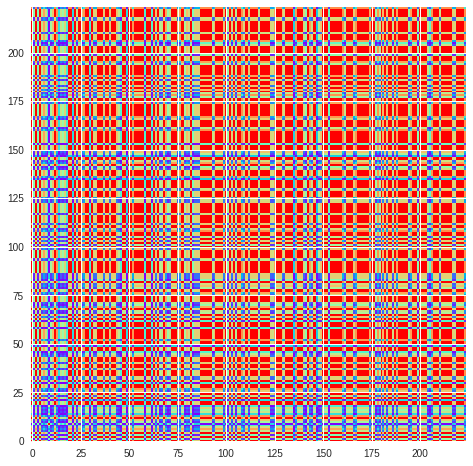

In [155]:
# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(img_train[0], cmap='rainbow', origin='lower')
plt.show()

### Dataset

In [0]:
transformations = None#get_transforms()

In [0]:
data = (ImageItemList
    .from_folder((path/DATASET/TRANSFORMATION))
    .split_by_folder(train='train', valid='test')
    .label_from_folder()
    .transform(transformations, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))

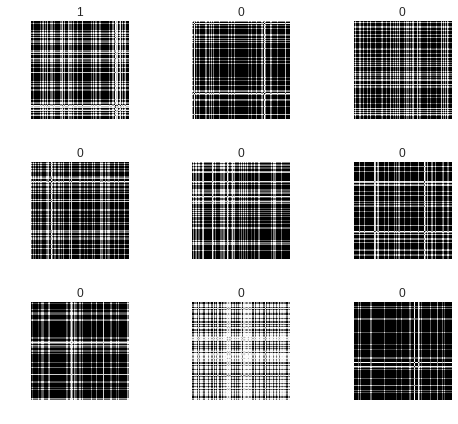

In [93]:
data.show_batch(3, figsize=(7,6))

In [94]:
print(data.classes)
len(data.classes),data.c

['1', '0']


(2, 2)

### Training: resnet34

In [0]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy, error_rate])

In [102]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


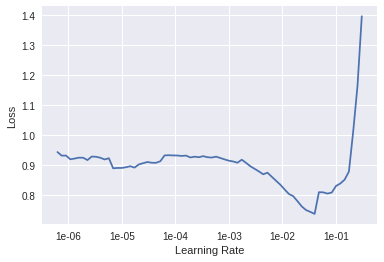

In [103]:
learn.recorder.plot()

In [104]:
learn.fit_one_cycle(4, 5e-3)

Total time: 00:17
epoch  train_loss  valid_loss  accuracy  error_rate
1      0.944812    0.589659    0.697842  0.302158    (00:04)
2      0.744944    0.665166    0.726619  0.273381    (00:04)
3      0.610160    0.702085    0.719424  0.280576    (00:04)
4      0.507903    0.677123    0.705036  0.294964    (00:04)



## GADF

In [0]:
DATASET = 'Earthquakes'
TRANSFORMATION = 'GADF'

In [0]:
tscls = TimeseriesClassification(DATASET, TRANSFORMATION)
tscls.create_imagenet_tree(path)

In [150]:
transfomer = tscls.create_transfomer()
# save training data
img_train = transfomer.fit_transform(X_train)
tscls.save_images(path, img_train, y_train, step='train')
# save testing data
img_test = transfomer.fit_transform(X_test)
tscls.save_images(path, img_test, y_test, step='test')

100%|██████████| 139/139 [00:01<00:00, 94.21it/s]


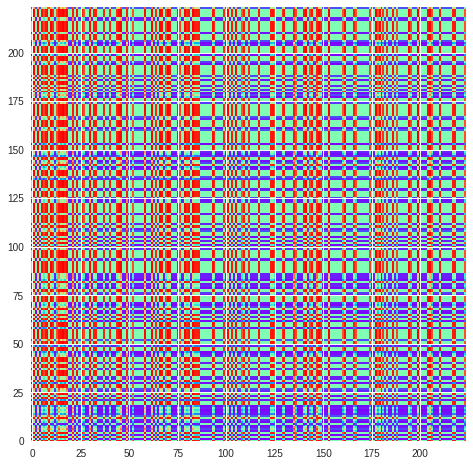

In [151]:
# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(img_train[0], cmap='rainbow', origin='lower')
plt.show()

### Dataset

In [0]:
transformations = None#get_transforms()

In [0]:
data = (ImageItemList
    .from_folder((path/DATASET/TRANSFORMATION))
    .split_by_folder(train='train', valid='test')
    .label_from_folder()
    .transform(transformations, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))

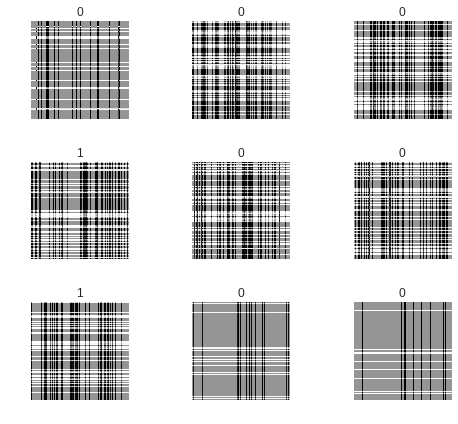

In [109]:
data.show_batch(3, figsize=(7,6))

### Training: resnet34

In [0]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy, error_rate])

In [111]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


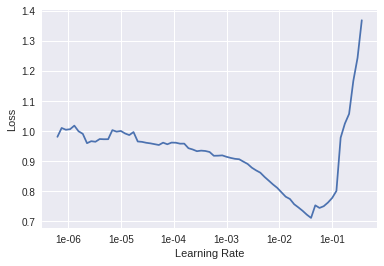

In [112]:
learn.recorder.plot()

In [113]:
learn.fit_one_cycle(4, 3e-3)

Total time: 00:17
epoch  train_loss  valid_loss  accuracy  error_rate
1      0.969402    0.663501    0.604317  0.395683    (00:04)
2      0.843445    0.770464    0.510791  0.489209    (00:04)
3      0.734087    1.006604    0.446043  0.553957    (00:04)
4      0.630751    1.017907    0.446043  0.553957    (00:04)



### Training: resset50

In [114]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 43528074.54it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


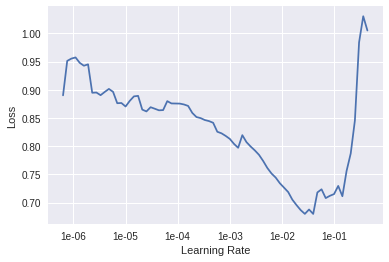

In [115]:
learn.lr_find()
learn.recorder.plot()

In [116]:
learn.fit_one_cycle(8, 5e-3)

Total time: 01:08
epoch  train_loss  valid_loss  error_rate
1      0.860175    0.563818    0.273381    (00:17)
2      0.679544    0.564484    0.266187    (00:07)
3      0.607729    0.729496    0.287770    (00:07)
4      0.569867    0.949778    0.258993    (00:07)
5      0.506279    0.874434    0.258993    (00:07)
6      0.497285    0.798650    0.287770    (00:07)
7      0.459215    0.800176    0.323741    (00:07)
8      0.434542    0.817872    0.302158    (00:07)



## MTF

In [0]:
tscls = TimeseriesClassification('Earthquakes', 'MTF')
tscls.create_imagenet_tree(path)

In [125]:
X_train.shape, X_test.shape

((322, 512), (139, 512))

In [126]:
transfomer = tscls.create_transfomer()
# save training data
img_train = transfomer.fit_transform(X_train)
tscls.save_images(path, img_train, y_train, step='train')
# save testing data
img_test = transfomer.fit_transform(X_test)
tscls.save_images(path, img_test, y_test, step='test')

IndexError: ignored

In [130]:
!cat -n /usr/local/lib/python3.6/dist-packages/pyts/image/image.py

     1	"""The :mod:`pyts.image` module includes imaging algorithms.
     2	
     3	Implemented algorithms are:
     4	- Gramian Angular Summation Field
     5	- Gramian Angular Difference Field
     6	- Markov Transition Field
     7	- Recurrence Plots
     8	"""
     9	
    10	from __future__ import division
    11	from __future__ import unicode_literals
    12	from __future__ import print_function
    13	from __future__ import absolute_import
    14	from future import standard_library
    15	import numpy as np
    16	import scipy.stats
    17	from sklearn.base import BaseEstimator, TransformerMixin
    18	from sklearn.preprocessing import MinMaxScaler
    19	from sklearn.utils.validation import check_array
    20	from ..approximation import PAA
    21	from ..utils import segmentation
    22	
    23	
    24	standard_library.install_aliases()
    25	
    26	
    27	class GASF(BaseEstimator, TransformerMixin):
    28	    """Gramian Angular Summation Field.
    29	
    30	    Parameters


In [132]:
!vim /usr/local/lib/python3.6/dist-packages/pyts/image/image.py

/bin/bash: vim: command not found


## RecurrencePlots

In [0]:
DATASET = 'Earthquakes'
TRANSFORMATION = 'RecurrencePlots'

In [0]:
tscls = TimeseriesClassification(DATASET, TRANSFORMATION)
tscls.create_imagenet_tree(path)

In [143]:
transfomer = tscls.create_transfomer()
# save training data
img_train = transfomer.fit_transform(X_train)
tscls.save_images(path, img_train, y_train, step='train')
# save testing data
img_test = transfomer.fit_transform(X_test)
tscls.save_images(path, img_test, y_test, step='test')

100%|██████████| 139/139 [00:03<00:00, 35.95it/s]


### Dataset

In [0]:
transformations = None#get_transforms()

In [0]:
data = (ImageItemList
    .from_folder((path/DATASET/TRANSFORMATION))
    .split_by_folder(train='train', valid='test')
    .label_from_folder()
    .transform(transformations, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))

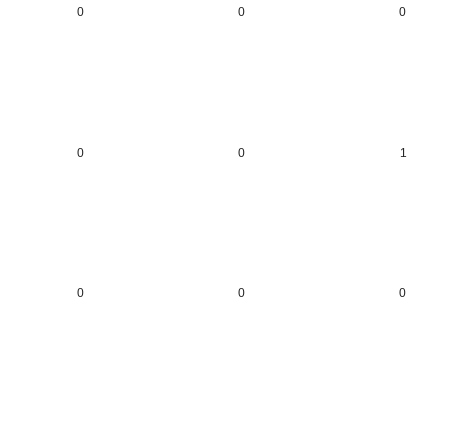

In [146]:
data.show_batch(rows=3, figsize=(7,6))

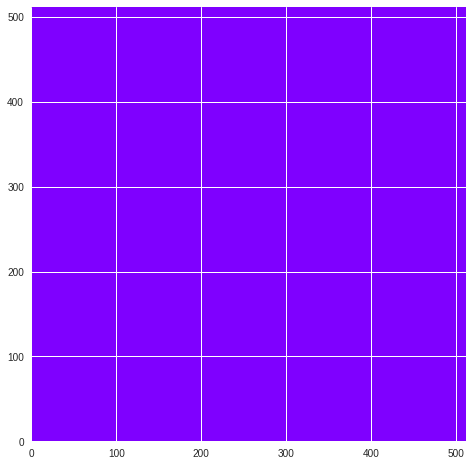

In [147]:
# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(img_train[0], cmap='rainbow', origin='lower')
plt.show()

### Training: resetnet34

In [0]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy, error_rate])

In [157]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


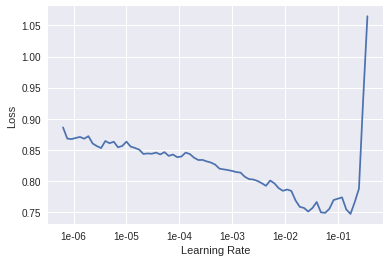

In [158]:
learn.recorder.plot()

In [159]:
learn.fit_one_cycle(8, 5e-4)

Total time: 02:10
epoch  train_loss  valid_loss  accuracy  error_rate
1      0.842617    2.091493    0.251799  0.748201    (00:24)
2      0.851110    0.684415    0.748201  0.251799    (00:16)
3      0.819808    3.758576    0.748201  0.251799    (00:15)
4      0.802961    8.250953    0.748201  0.251799    (00:14)
5      0.777559    2.159550    0.748201  0.251799    (00:14)
6      0.756242    0.590085    0.748201  0.251799    (00:14)
7      0.751708    3.850726    0.748201  0.251799    (00:14)
8      0.735907    47.651451   0.251799  0.748201    (00:14)



## PyTS Classifiers

### BOSSVSClassifier

In [173]:
bossvs = BOSSVSClassifier(n_coefs=4, window_size=24)
bossvs.fit(X_train, y_train)

BOSSVSClassifier(n_bins=4, n_coefs=4, norm_mean=True, norm_std=True,
         numerosity_reduction=True, quantiles='empirical', smooth_idf=True,
         sublinear_tf=True, variance_selection=False,
         variance_threshold=0.0, window_size=24)

In [174]:
# Inspect the performance
y_pred = bossvs.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.64      0.71       104
          1       0.31      0.49      0.38        35

avg / total       0.67      0.60      0.63       139



In [0]:
# Confusion matrices
cm_boss = confusion_matrix(y_test, y_pred)
cm_boss = cm_boss.astype('float') / cm_boss.sum(axis=1)[:, np.newaxis]

### SAXVSMClassifier

In [176]:
saxvsm = SAXVSMClassifier()
saxvsm.fit(X_train, y_train)

SAXVSMClassifier(n_bins=4, numerosity_reduction=True, quantiles='empirical',
         smooth_idf=True, sublinear_tf=False, use_idf=True, window_size=4)

In [177]:
# Inspect the performance
y_pred = saxvsm.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.88      0.81       104
          1       0.32      0.17      0.22        35

avg / total       0.65      0.70      0.66       139



In [0]:
# Confusion matrices
cm_saxvsm = confusion_matrix(y_test, y_pred)
cm_saxvsm = cm_saxvsm.astype('float') / cm_saxvsm.sum(axis=1)[:, np.newaxis]

### KNNClassifier

In [179]:
knn = KNNClassifier()
knn.fit(X_train, y_train)

KNNClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
       metric_params=None, n_jobs=1, n_neighbors=1, p=2, weights='uniform')

In [189]:
# Inspect the performance
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.77      0.88      0.82       104
          1       0.38      0.23      0.29        35

avg / total       0.67      0.71      0.69       139



In [0]:
# Confusion matrices
cm_knn = confusion_matrix(y_test, y_pred)
cm_knn = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]

### Interpretation

In [0]:
n_classes = 2
dictionary = {"BOSSVSClassifier": cm_boss,
              "SAXVSMClassifier": cm_saxvsm,
              "KNNClassifier": cm_knn}

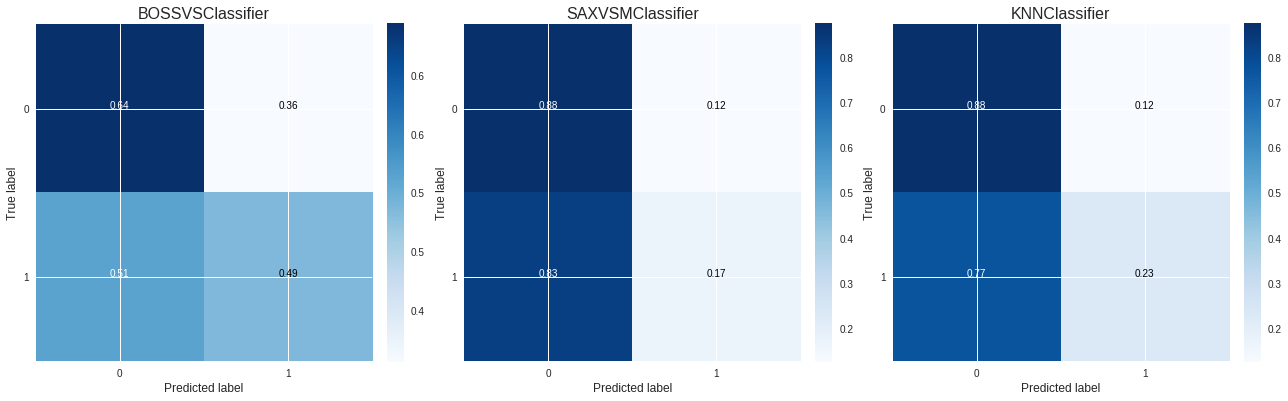

In [192]:
# Plot confusion matrices
plt.figure(figsize=(18, 6))
for idx, (title, cm) in zip(range(1, 4), dictionary.items()):
    plt.subplot(130 + idx)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '0.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.colorbar(fraction=0.046, pad=0.04, format='%.1f')
    plt.title(title, fontsize=16)
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
plt.show()